# Задание 6

### Задача
Используя коэффициент корреляции Пирсона и парный t-критерий Стьюдента для зависимых выборок сравнить два набора данных.

### План
- Сделать датасеты
- Сделать функцию, реализующую парный t-критерий Стьюдента
- Проверить работу функции, сравнивая свои наборы данных

### Размышления
Для проверки работы функции сделаю три датасета: 
- первый, с нормальным распределением
- второй, такой же как первый, только каждый элемент больше на n
- третий, не с нормальным распределением, а, например с распределением Парето

Сравню их.
Буду считать что функция работает верно если:
- первый и второй датасеты сходны
- первый (или второй) и третий датасеты различны

Чтобы быть уверенным что ошибка будет только в функции, датасеты должны иметь именно такое распределение как было задумано. Для этого сгенерирую наборы данных с помощью модуля random.

### Работа

In [524]:
from random import normalvariate
from random import paretovariate

In [525]:
# параметры и служебные переменные для построения датасетов
someMean=50      #среднее для нормального распределения
someSigma=15     #отклонение для нормального распределения
someAlpha=100    #альфа-параметр для расп. Парето
dataLen=50       #размер датасетов
n=5              #разница между і-тым элементом первого и второго датасетов

In [526]:
normDistr1 = [ normalvariate(someMean, sigma) for i in range(dataLen) ]
normDistr2 = [ normDistr1[i]+n for i in range(dataLen) ]
paretoDistr = [ paretovariate(someAlpha) for i in range(dataLen) ]

Есть. Теперь оценю насколько данные из наборов связаны. Для этого напишу функцию, которая посчитает коэффициент корреляции Пирсона.

(наверное можно было бы взять из предыдущей лабы, но там распределение частот дискретных величин, а тут - непрерывных).

In [527]:
from math import sqrt
from numpy import mean

In [528]:
def PearsonCorrel_1(data1, data2):
    n=len(data1)
    if n!=len(data2):
        print("Разные длины массивов!")
        return
    part1=0 #сумма (Хі*Уі)
    part2=0 #(сумма Хі)*(сумма Уі)
    part3=0 #сумма Хі
    part4=0 #сумма квадратов Хі
    part5=0 #сумма Уі
    part6=0 #сумма квадратов Уі
    
    for i in range(n):
        part1 += data1[i]*data2[i]    #сумма (Хі*Уі)
        part3 += data1[i]             #сумма Хі
        part4 += data1[i]**2          #сумма квадратов Хі
        part5 += data2[i]             #сумма Уі 
        part6 += data2[i]**2          #сумма квадратов Уі
    part2=part3*part5                 #(сумма Хі)*(сумма Уі)
    
    numerator=n*part1 - part2
    denominator =sqrt( (n*part4 - part3**2) * (n*part6 - part5**2) )
    r=numerator/denominator
    return r

Первая реализация работала некорректно, пришлось написать другую. 
Первая была исправлена потом, но я решил её оставить

In [529]:
def PearsonCorrel_2(data1, data2):
    n=len(data1)
    if n!=len(data2):
        print("Массивы разной длины!")
        return
    Xm=mean(data1)
    Ym=mean(data2)
    part1=0 #сумма (xi-xm)
    part2=0 #сумма (yi-ym)
    part3=0 #сумма (xi-xm)*(yi-ym)
    part4=0 # кв.кор. сумма (xi-xm) * сумма (yi-ym)
    
    for i in range(n):
        part1+= (data1[i]-Xm)**2
        part2+= (data2[i]-Ym)**2
        part3+= ((data1[i]-Xm) * (data2[i]-Ym))
    part4=sqrt(part1 * part2)
    
    numerator = part3
    denominator = part4
    r=numerator/denominator
    return r

Функции сложные, проверю правильно ли они работают

In [530]:
print(PearsonCorrel_1(normDistr1, normDistr1))
print(PearsonCorrel_1(normDistr1, paretoDistr))
print(PearsonCorrel_2(normDistr1, normDistr1))
print(PearsonCorrel_2(normDistr1, paretoDistr))

1.0
-0.0761820823187602
1.0
-0.07618208231893152


Результаты говорят о том что одинаковые датасеты полностью 
зависят друг от друга, а разные - соответственно - не зависят.

Функции работают корректно

Для оценки степени значимости связи организую отдельную функцию

In [531]:
def CorrelEstimator(someR):
    if someR<0: return "нет"
    if someR>0 and someR<0.3: return "очень низкий"
    if someR>0.31 and someR<0.5: return "низкий"
    if someR>51 and someR<0.7: return "средний"
    if someR>0.71 and someR<0.9: return "высокий"
    if someR>0.91 and someR<1.0: return "очень высокий"
    if someR>=1.0: return "есть статистически значимая зависимость"
    

Теперь напишу функцию, которая будет находть число степеней свободы df из таблицы.
Таблица со значениями находится в рабочей директории анаконды.


Для поиска организую вспомагательную функцию.
Пусть это будет бинарный поиск.

In [532]:
def BinSearch(data, val):
    high=len(data)-1
    mid=len(data)//2
    low=0
    
    while data[mid]!=val and low<=high:
        if data[mid]<val: low = mid
        else: high=mid
        mid=(low+high)//2
    
    if low>high: return "Не найдено"
    else: return mid

In [533]:
from pandas import read_excel

In [534]:
def GetT(someDf):
    array=read_excel("pairedCriterionCritVal.xlsx")
    tIdx=BinSearch(array["df"], someDf)
    tTab=array[0.05][tIdx]
    return 0-tTab

Функция, которая находит разницу между элементами массивов:

In [535]:
def DifferCalc(data1, data2):
    n=len(data1)
    if n!=len(data2): return "Массивы разной длины!"
    dArr=[data1[i]-data2[i] for i in range(n)]
    return dArr

Собственно функция, которая будет вычислять t-критерий Стьюдента

In [536]:
from numpy import std

In [552]:
def StudentCriterion(data1, data2):
    dArr=DifferCalc(data1, data2)
    n=len(dArr)
    M=mean(dArr)
    sigma=std(dArr)**2
    tCriterion=(M/sigma)*sqrt(n)
    df=n-1
    return 0-tCriterion, df
StudentCriterion(normDistr1, normDistr2)

(1.7507115929620666e+31, 49)

Для вызова этих функций организую отдельную функцию, которая сравнит три набора данных и выведет:
- Коэффициент корреляции Пирсона (чтобы было видно правильно ли работает его вычисление)
- Уровень значимости связи
- Число степеней свободы
- Эмпирическое значние t-критерия Стьюдента
- Табличное значние t-критерия Стьюдента
- Есть ли статистическая зависимость

In [553]:
def main(data1, data2):
    r=PearsonCorrel_2(data1, data2)
    correlStr=CorrelEstimator(r)
    tCritEmp, df = StudentCriterion(data1, data2)
    tCritTab = GetT(df)
    isDep= "нет" 
    if tCritEmp>tCritTab:
        isDep = "есть"
    print("Коэф. Пирсона:     ", r)
    print("Ур.знач. связи:    ", correlStr)
    print("Степени свободы:   ", df)
    print("Эмп. t-критерий:   ", tCritEmp)
    print("Табл. t-критерий:  ", tCritTab)
    print("Стат. зависимость: ", isDep)

    print()

### Результат

Для наглядности построю графики распределения частот в наборах

In [554]:
import matplotlib.pyplot as plt

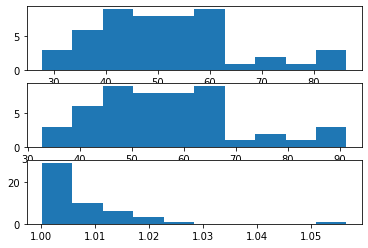

In [555]:
plt.figure(1)
plt.subplot(3,1,1)
plt.hist(normDistr1);
plt.subplot(3,1,2)
plt.hist(normDistr2);
plt.subplot(3,1,3)
plt.hist(paretoDistr);

In [556]:
print("Нормальное1 и Нормальное2")
main(normDistr1, normDistr2)
print("Нормальное1 и Парето")
main(normDistr1, paretoDistr)
print("Нормальное2 и Парето")
main(normDistr2, paretoDistr)

Нормальное1 и Нормальное2
Коэф. Пирсона:      1.0
Ур.знач. связи:     есть статистически значимая зависимость
Степени свободы:    49
Эмп. t-критерий:    1.7507115929620666e+31
Табл. t-критерий:   -2.01
Стат. зависимость:  есть

Нормальное1 и Парето
Коэф. Пирсона:      -0.07618208231893152
Ур.знач. связи:     нет
Степени свободы:    49
Эмп. t-критерий:    -1.9293921352561432
Табл. t-критерий:   -2.01
Стат. зависимость:  есть

Нормальное2 и Парето
Коэф. Пирсона:      -0.07618208231893152
Ур.знач. связи:     нет
Степени свободы:    49
Эмп. t-критерий:    -2.120357749324915
Табл. t-критерий:   -2.01
Стат. зависимость:  нет



### Выводы
Полученные значения критерия Пирсона, значимости связи и t-критерия Стьюдента говорят о следующем:
- Функция  работает корректно
- Первые два датасета взаимосвязаны
- Первый и третий датасеты различны
- Второй и третий датасеты различны

Что также подтверждает вид гистограмм